# Time series

This is a notebook to understand how we can work with time series. In the last notebook, we learned how we can create simple linear regression models based on **time dependence**(aka time step features) and **serial dependence** (aka Lag features).

Now we want to explore time series decomposition into three main components
- Trend
- Seasonality
- Error

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv("./elecdemand.csv", 
                 index_col="Datetime", 
                 parse_dates=True, 
                 infer_datetime_format=True)
print(df.shape)
df.head()

(2016, 1)


,Demand
Datetime,
2000-06-05 00:00:00,44018
2000-06-05 01:00:00,45006
2000-06-05 02:00:00,44862
2000-06-05 03:00:00,43988
2000-06-05 04:00:00,43087


In [8]:
# statsmodel.tsa refer to time series functinos of statsmodel module
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
import matplotlib.pyplot as plt 
import seaborn as sns

# Indentifying Trend of the model

## By using a rolling mean

In [35]:
elec_demand = df.loc[:,'Demand']
elec_demand.head(25)

Datetime
2000-06-05 00:00:00    44018
2000-06-05 01:00:00    45006
2000-06-05 02:00:00    44862
2000-06-05 03:00:00    43988
2000-06-05 04:00:00    43087
2000-06-05 05:00:00    43539
2000-06-05 06:00:00    52115
2000-06-05 07:00:00    64549
2000-06-05 08:00:00    71462
2000-06-05 09:00:00    74130
2000-06-05 10:00:00    74946
2000-06-05 11:00:00    75636
2000-06-05 12:00:00    75373
2000-06-05 13:00:00    73920
2000-06-05 14:00:00    73708
2000-06-05 15:00:00    73585
2000-06-05 16:00:00    75019
2000-06-05 17:00:00    73888
2000-06-05 18:00:00    69938
2000-06-05 19:00:00    66587
2000-06-05 20:00:00    64155
2000-06-05 21:00:00    65422
2000-06-05 22:00:00    63146
2000-06-05 23:00:00    55032
2000-06-06 00:00:00    49413
Name: Demand, dtype: int64

In [31]:
# Set Matplotlib defaults
sns.set_style('whitegrid')
plt.rc("figure", autolayout=True, figsize=(11,5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

<Axes: xlabel='Datetime'>

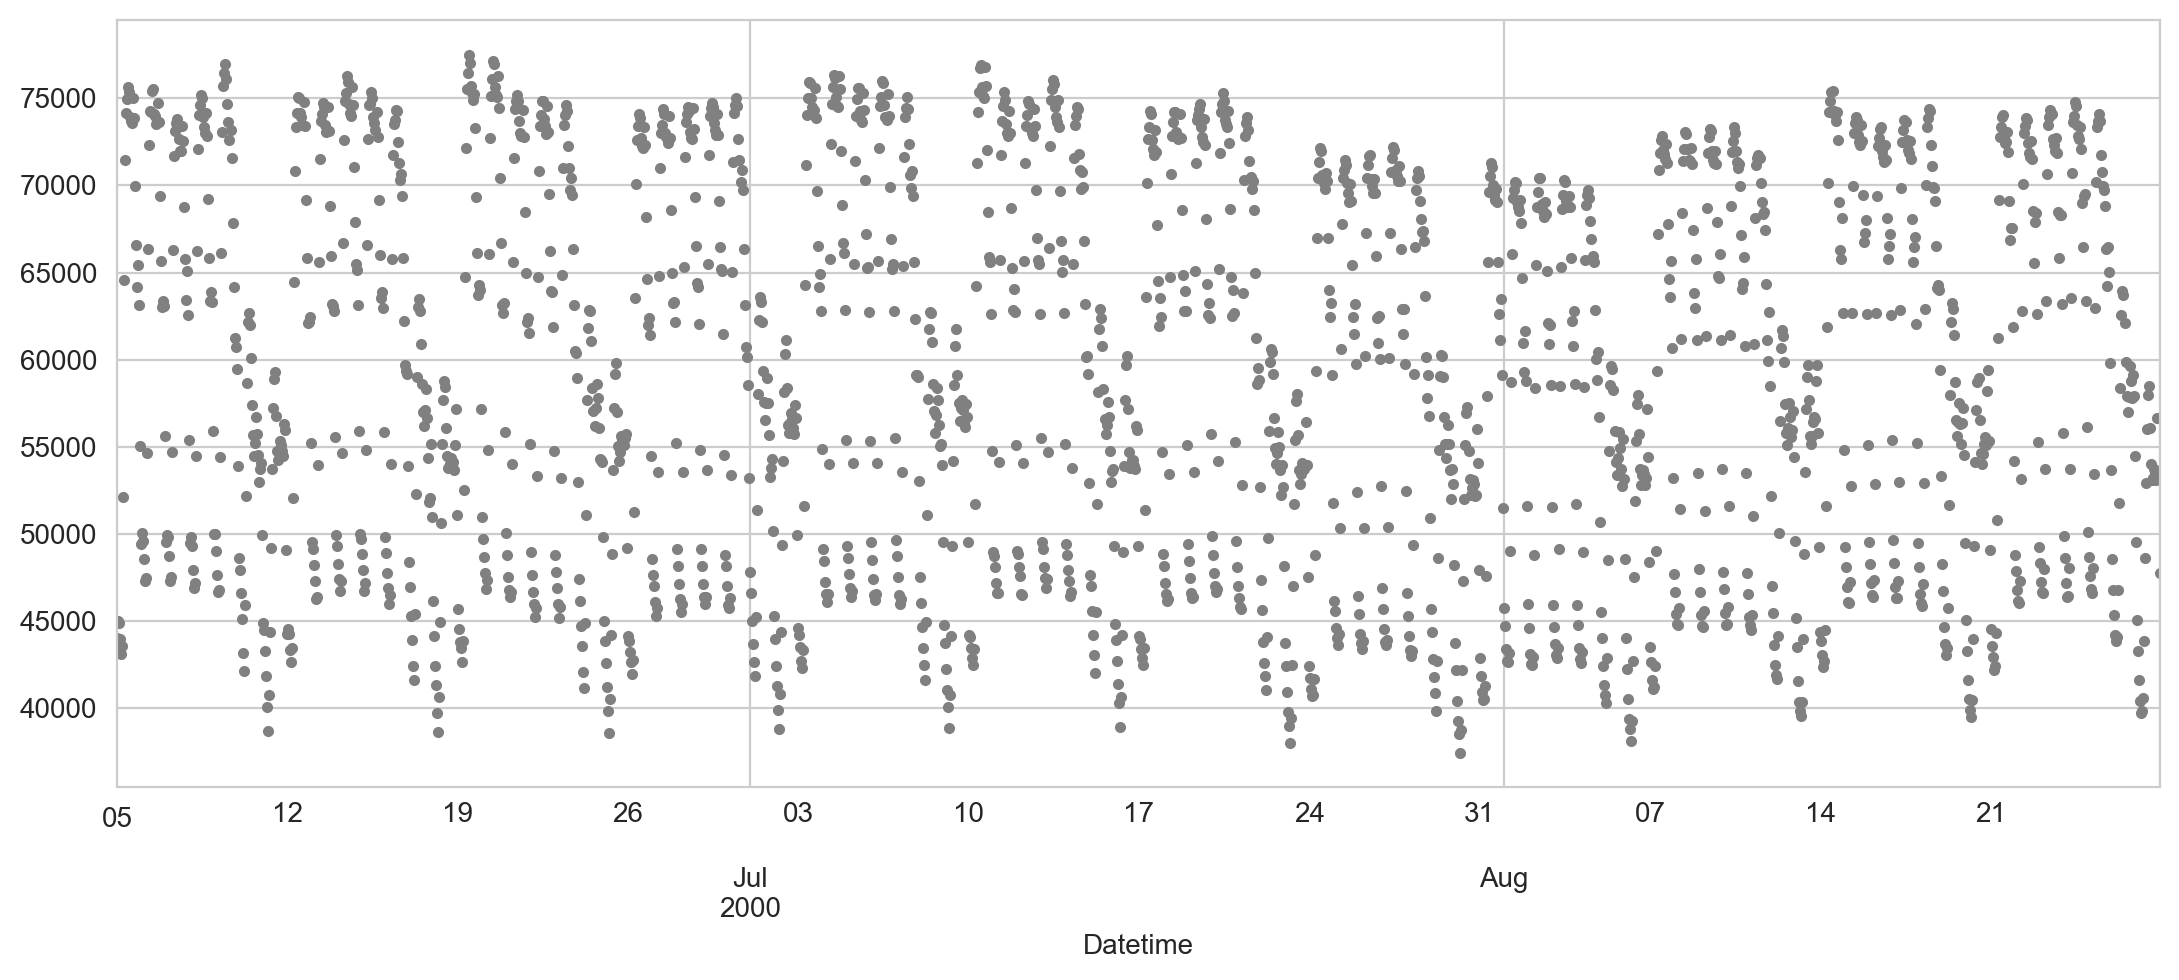

In [32]:
elec_demand.plot(style=".", color="0.5")

<Axes: title={'center': 'Electricity Demand - 24 hours moving average'}, xlabel='Datetime'>

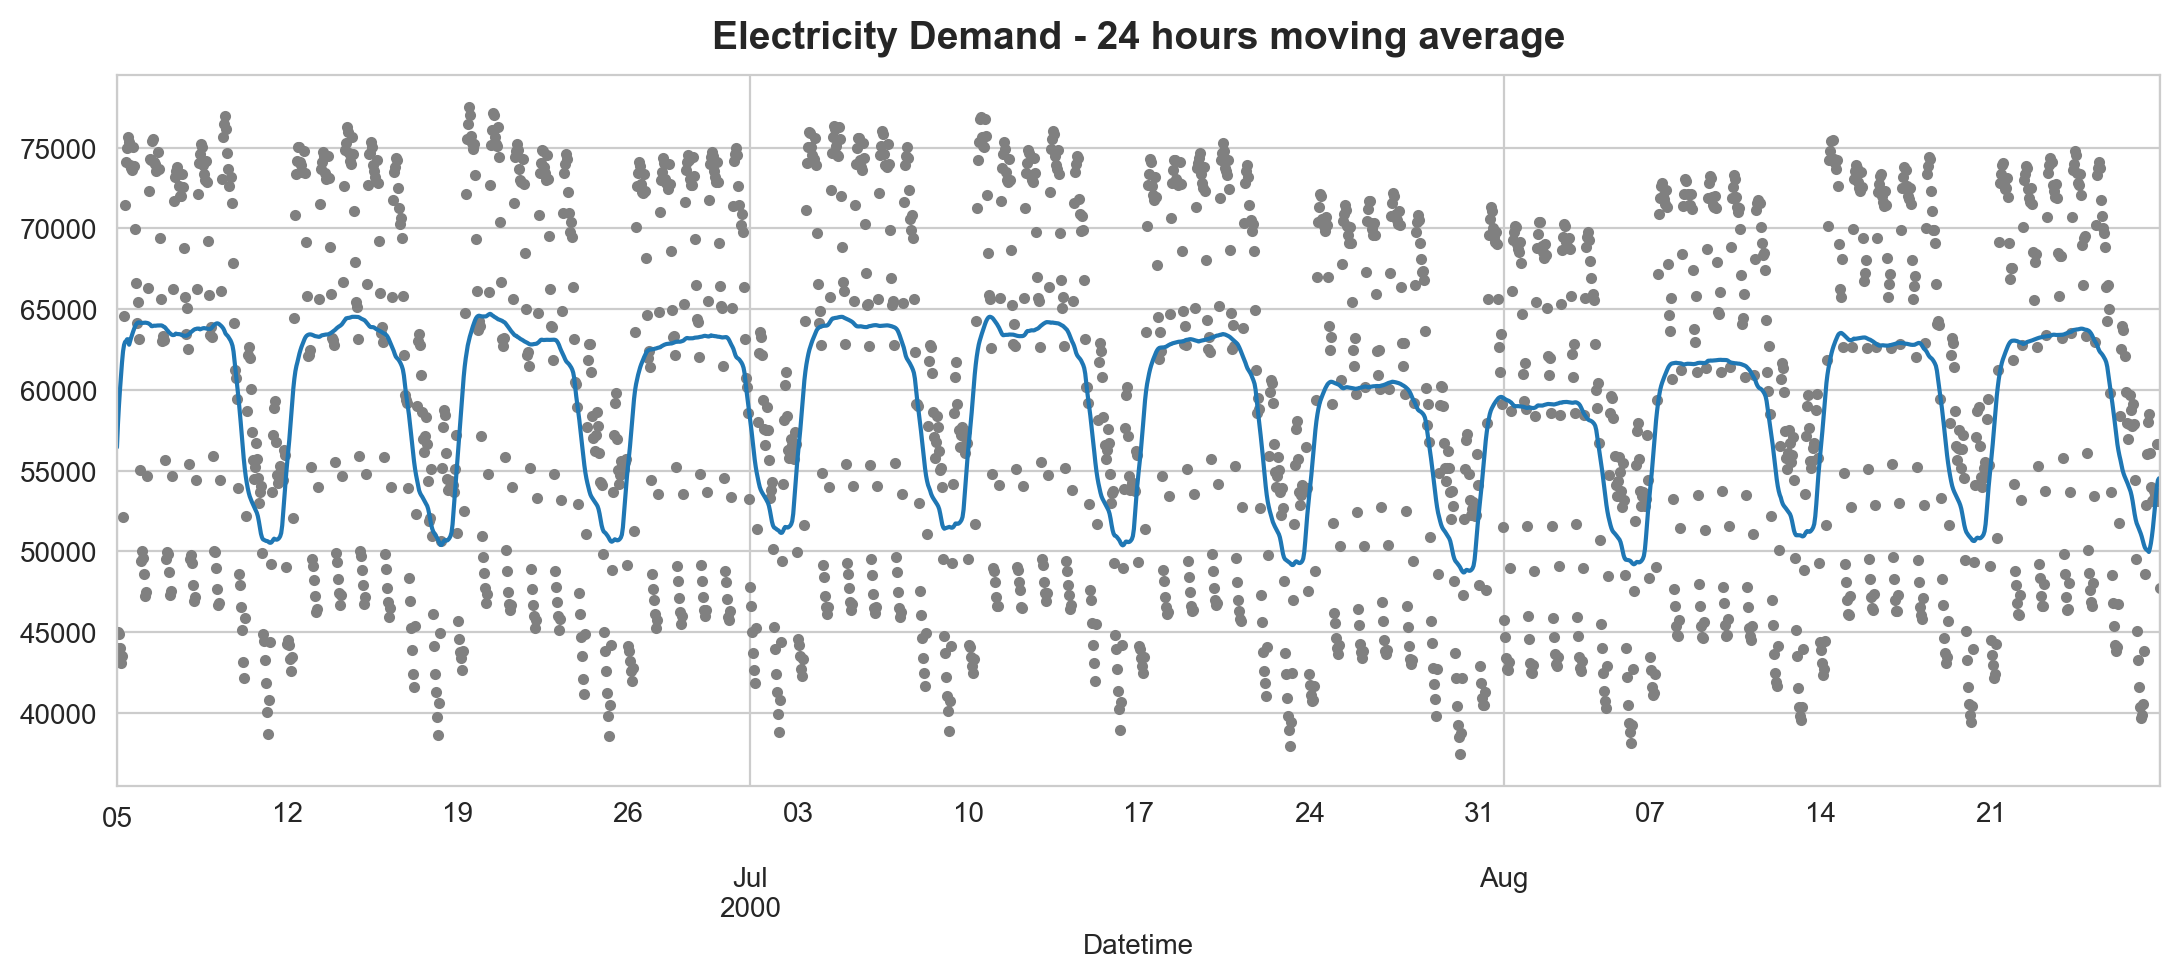

In [41]:
# Data is obtained hourly and seasonality seem to happen intra-day
# 1 day (24 hours) moving average should be Ok to model trend
moving_average  = elec_demand.rolling(window=1*24,
                                      min_periods=1*12,
                                      center=True).mean()

ax = elec_demand.plot(style='.', color="0.5")

moving_average.plot(ax=ax, title="Electricity Demand - 24 hours moving average", legend=False)

As we can see, we were not able to identify a trend line in here, we should probably expand for a 1-week moving average in order to eliminate the heavy effect of nights

<Axes: title={'center': 'Electricity Demand - 24 hours moving average'}, xlabel='Datetime'>

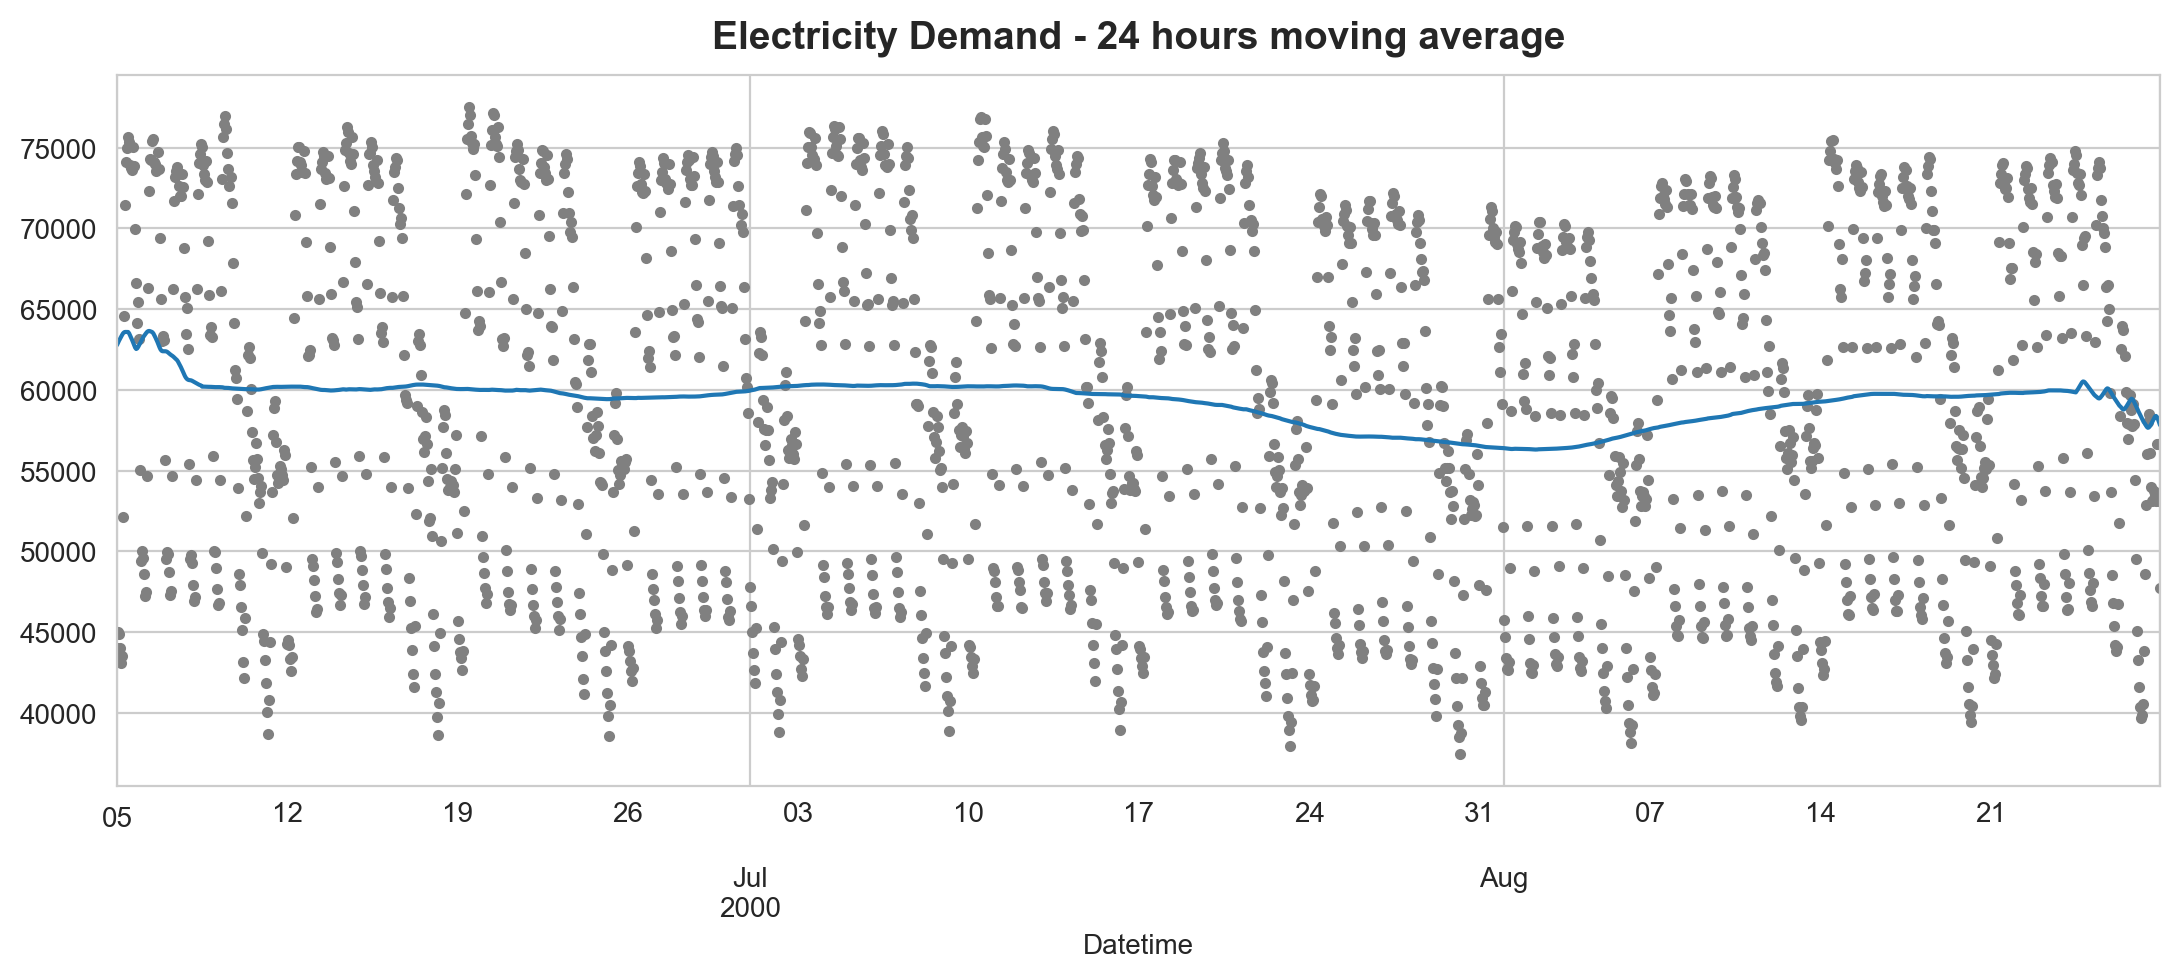

In [45]:
moving_average  = elec_demand.rolling(window=7*24,
                                      min_periods=7*12,
                                      center=True).mean()

ax = elec_demand.plot(style='.', color="0.5")

moving_average.plot(ax=ax, title="Electricity Demand - 24 hours moving average", legend=False)

## By using DeterministicProcess

In [46]:
from statsmodels.tsa.deterministic import DeterministicProcess

In [83]:
dp = DeterministicProcess(index= elec_demand.index, order = 2)
X = dp.in_sample()
X.head()

,trend,trend_squared
Datetime,,
2000-06-05 00:00:00,1.0,1.0
2000-06-05 01:00:00,2.0,4.0
2000-06-05 02:00:00,3.0,9.0
2000-06-05 03:00:00,4.0,16.0
2000-06-05 04:00:00,5.0,25.0


In [84]:
from sklearn.linear_model import LinearRegression

In [85]:
y = elec_demand
model = LinearRegression()
model.fit(X,y)
y_pred = pd.Series(model.predict(X), index=X.index)

In [86]:
NUM_DAYS_FORECAST = 1

fore_start_offset = pd.tseries.offsets.DateOffset(hours=1)
fore_index = pd.date_range(start=X.index.max() + fore_start_offset, periods=24*NUM_DAYS_FORECAST)
fore_index

DatetimeIndex(['2000-08-28', '2000-08-29', '2000-08-30', '2000-08-31',
               '2000-09-01', '2000-09-02', '2000-09-03', '2000-09-04',
               '2000-09-05', '2000-09-06', '2000-09-07', '2000-09-08',
               '2000-09-09', '2000-09-10', '2000-09-11', '2000-09-12',
               '2000-09-13', '2000-09-14', '2000-09-15', '2000-09-16',
               '2000-09-17', '2000-09-18', '2000-09-19', '2000-09-20'],
              dtype='datetime64[ns]', freq='D')

In [87]:
# 3 days forecast
X_fore = dp.out_of_sample(steps=24*NUM_DAYS_FORECAST, forecast_index=fore_index)

y_fore = pd.Series(model.predict(X_fore), index= X_fore.index)

<Axes: title={'center': 'Electricity Demand Trend Linear Regression'}, xlabel='Datetime'>

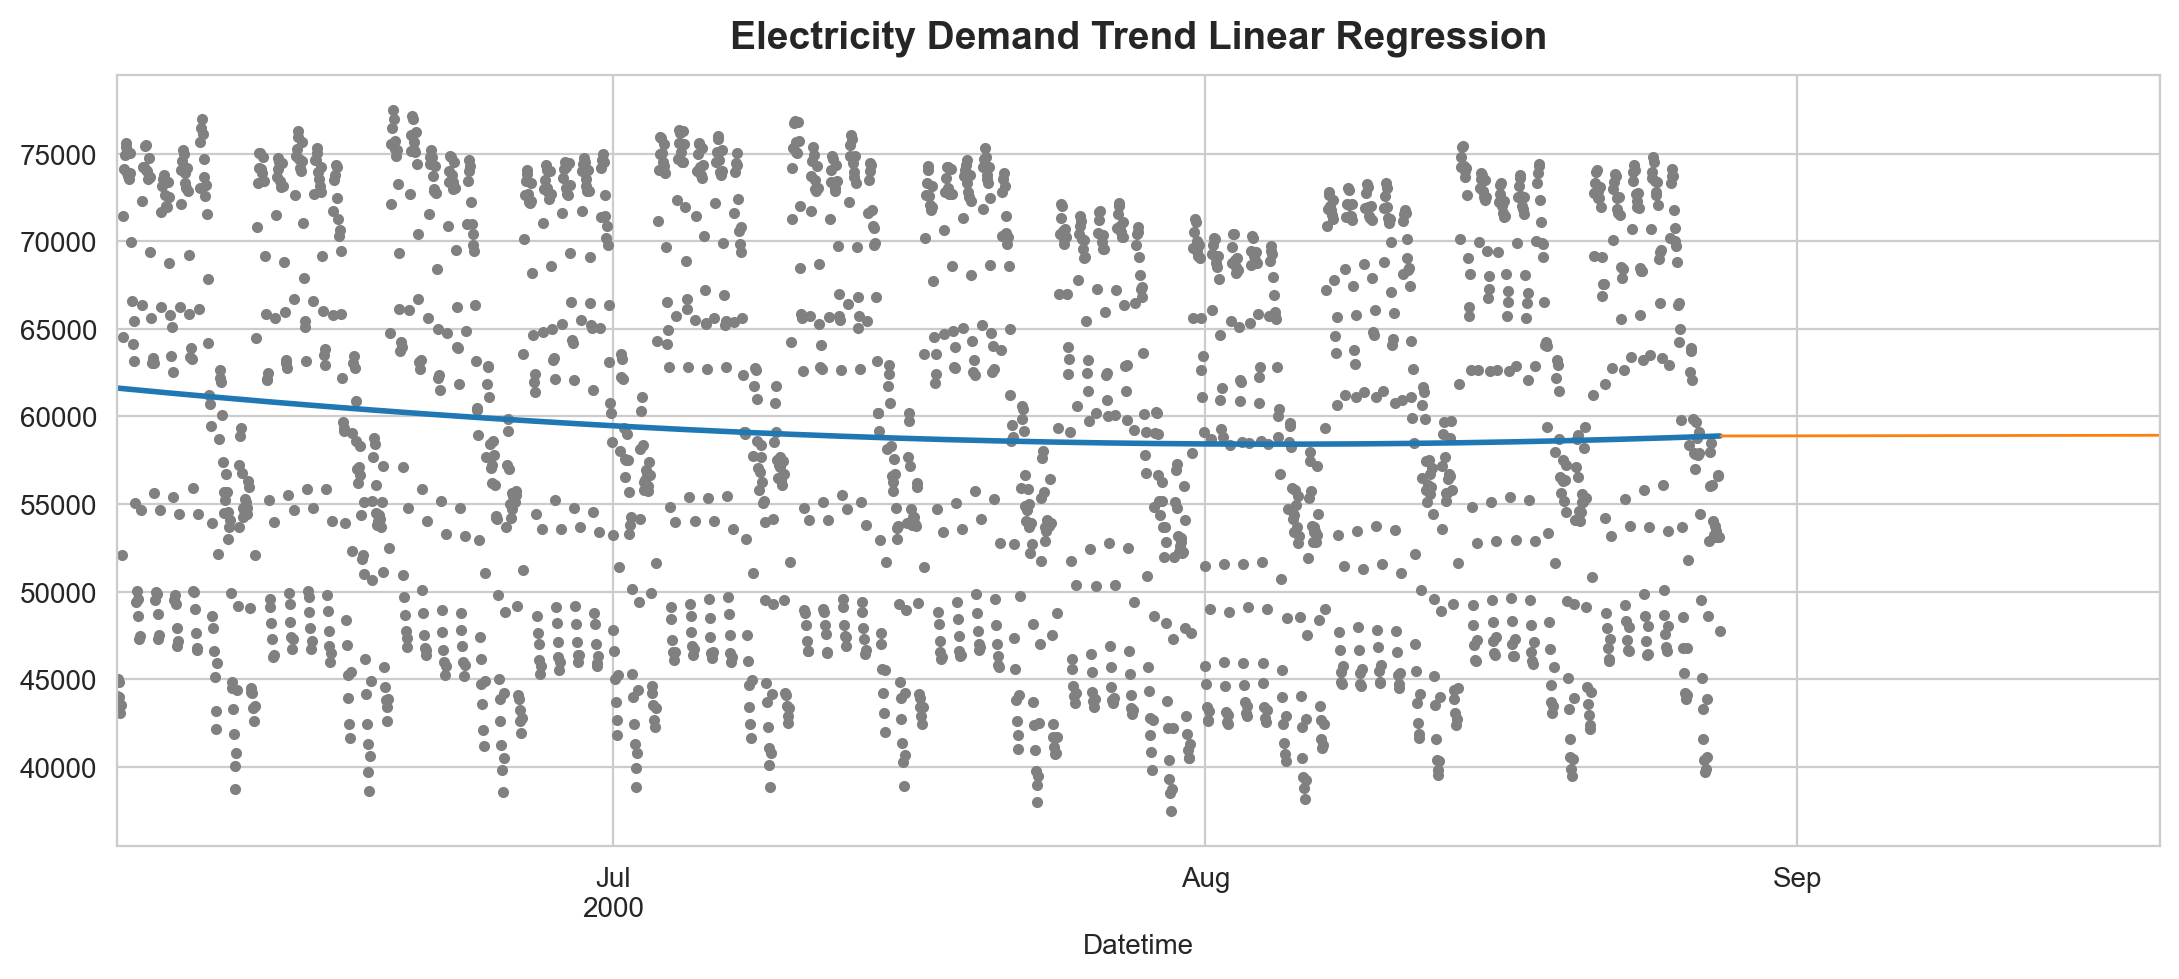

In [88]:
ax = elec_demand.plot(style=".", color="0.5", title="Electricity Demand Trend Linear Regression")

y_pred.plot(ax=ax, linewidth=2, label="Trend")
y_fore.plot(ax=ax, linewidth=1, label="3 days forecast")

# Identifying seasonality of the model

## Seasonal indicators
Basically we are plotting multiple periods of the time-series.
Feature engineering is quite like one-hot encoding

## Fourier transformation features and the periodoram
- Identify number of fourier features with periodogram
- Fit fourier features based on that

In [90]:
import numpy as np

def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1/freq) * time
    features = {}
    
    # For each order, adds a sin and a cos feature based on the freq
    for i in range (1, order + 1):
        features.update({
            f"sin{freq}_{i}": np.sin(i * k),
            f"cos{freq}_{i}": np.cos(i * k),
        })
    
    return pd.DataFrame(features, index=index)

In [92]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

In [100]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors = X[period].nunique())
    
    ax = sns.lineplot(
        x= freq,
        y= y,
        hue= period,
        data= X,
        ax= ax,
        palette= palette, 
        legend= False
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6,0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center"
        )
    return ax

In [111]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    frequencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window='boxcar',
        scaling='spectrum',
    )
    
    if ax is None:
        _, ax = plt.subplots()
    
    ax.step(frequencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1,2,4,6,12,26,52,104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodgram")
    return ax

In [91]:
tunnel = pd.read_csv("tunnel.csv", parse_dates=["Day"])
tunnel = tunnel.set_index("Day").to_period("D")

<Axes: title={'center': 'Seasonal Plot (year/dayofyear)'}, xlabel='dayofyear', ylabel='NumVehicles'>

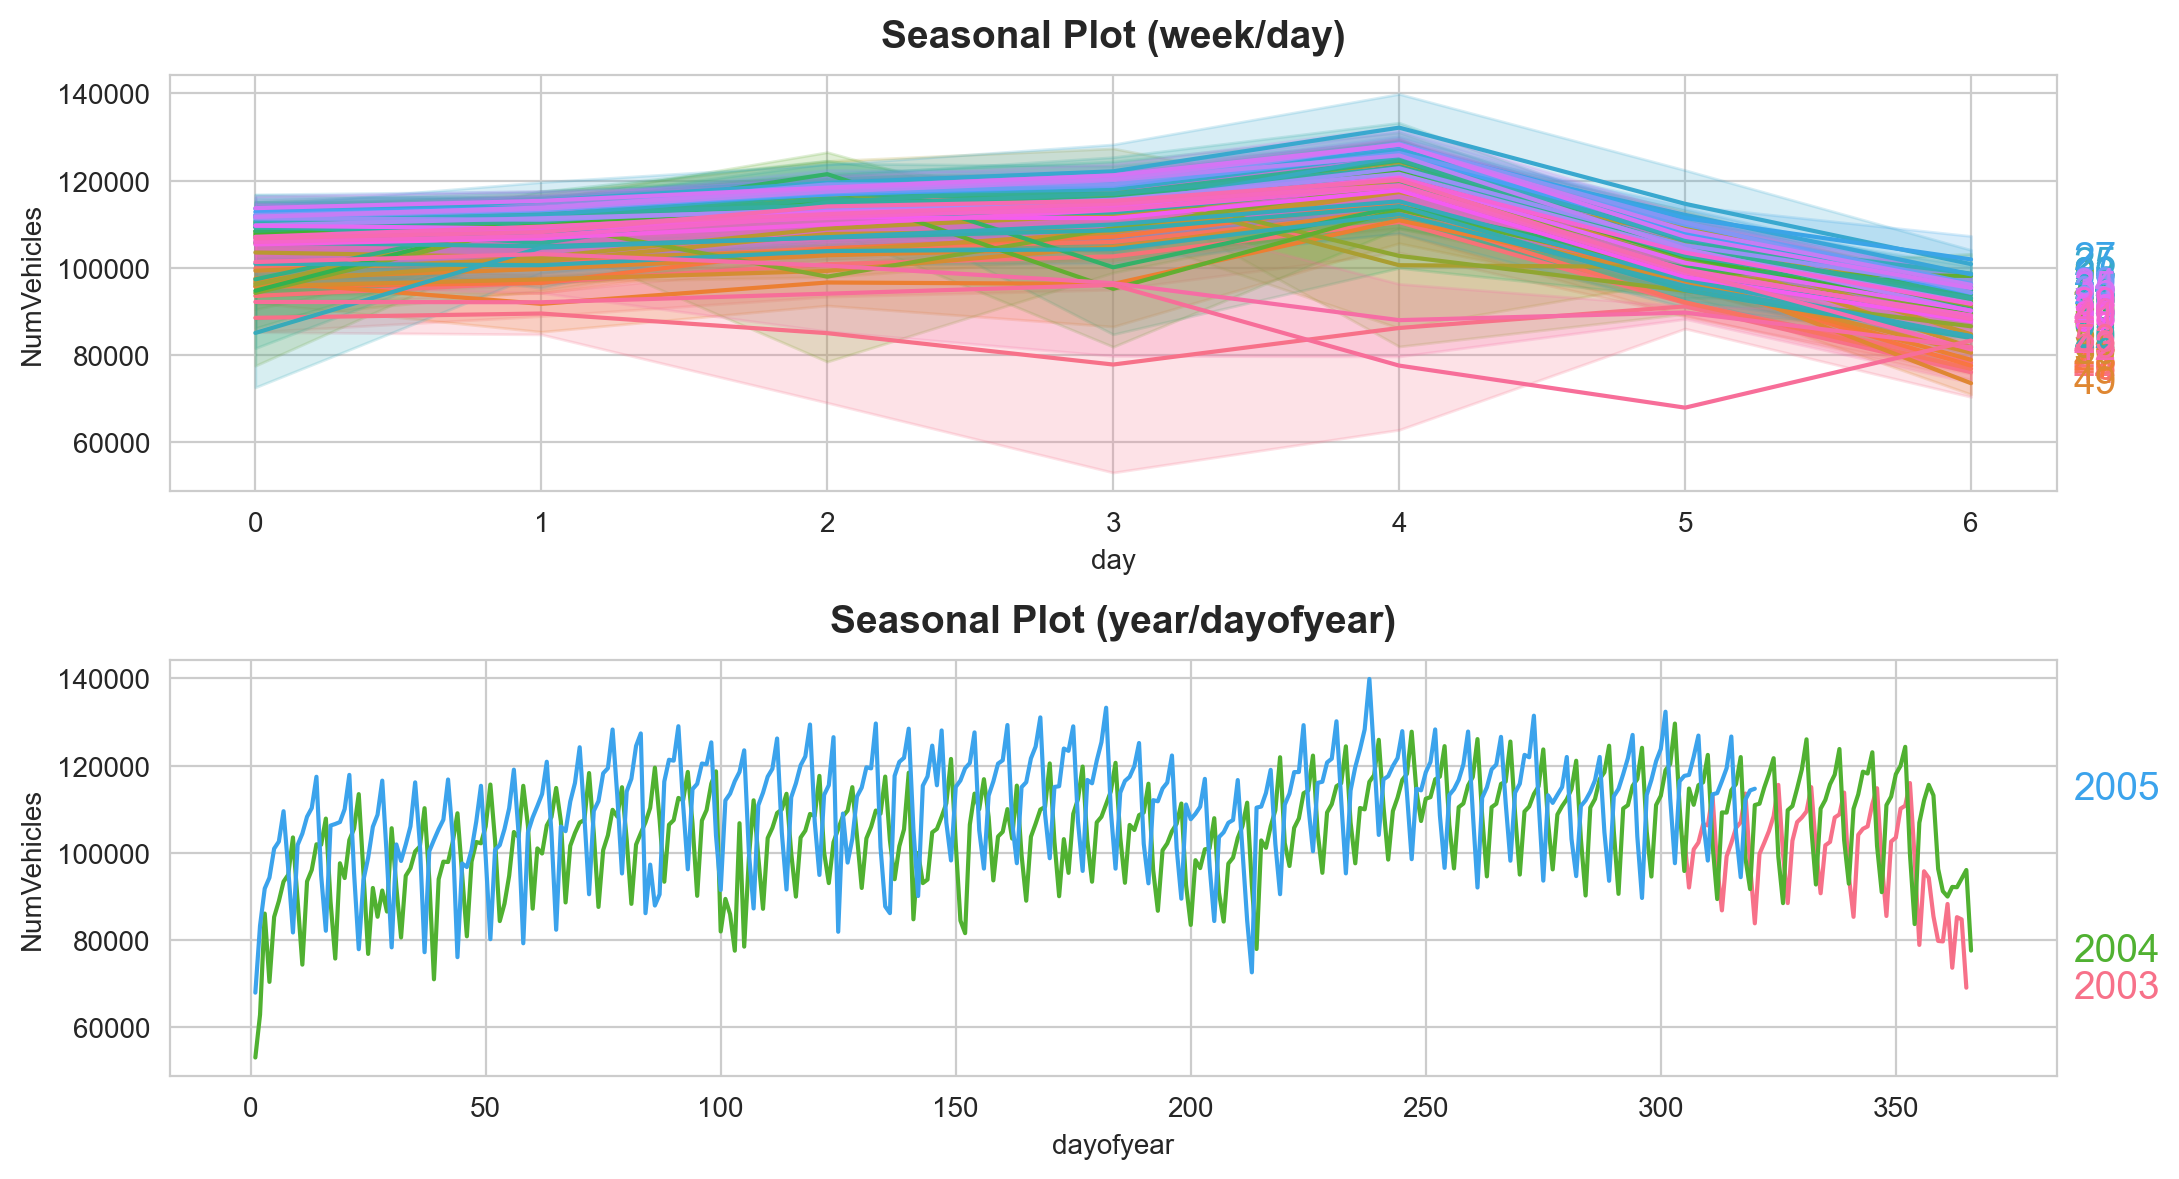

In [103]:
X = tunnel.copy()

# Seasonal plot
X["day"] = X.index.dayofweek # the x-axis (freq)
X["week"] = X.index.week # the seasonal period (period)

# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
fig, (ax0, ax1) = plt.subplots(2,1, figsize=(11,6))
seasonal_plot(X, y="NumVehicles", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="NumVehicles", period="year", freq="dayofyear", ax=ax1)

C:\Users\gransotto gustavo\AppData\Local\Temp\ipykernel_17144\2793126112.py:3: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1D")


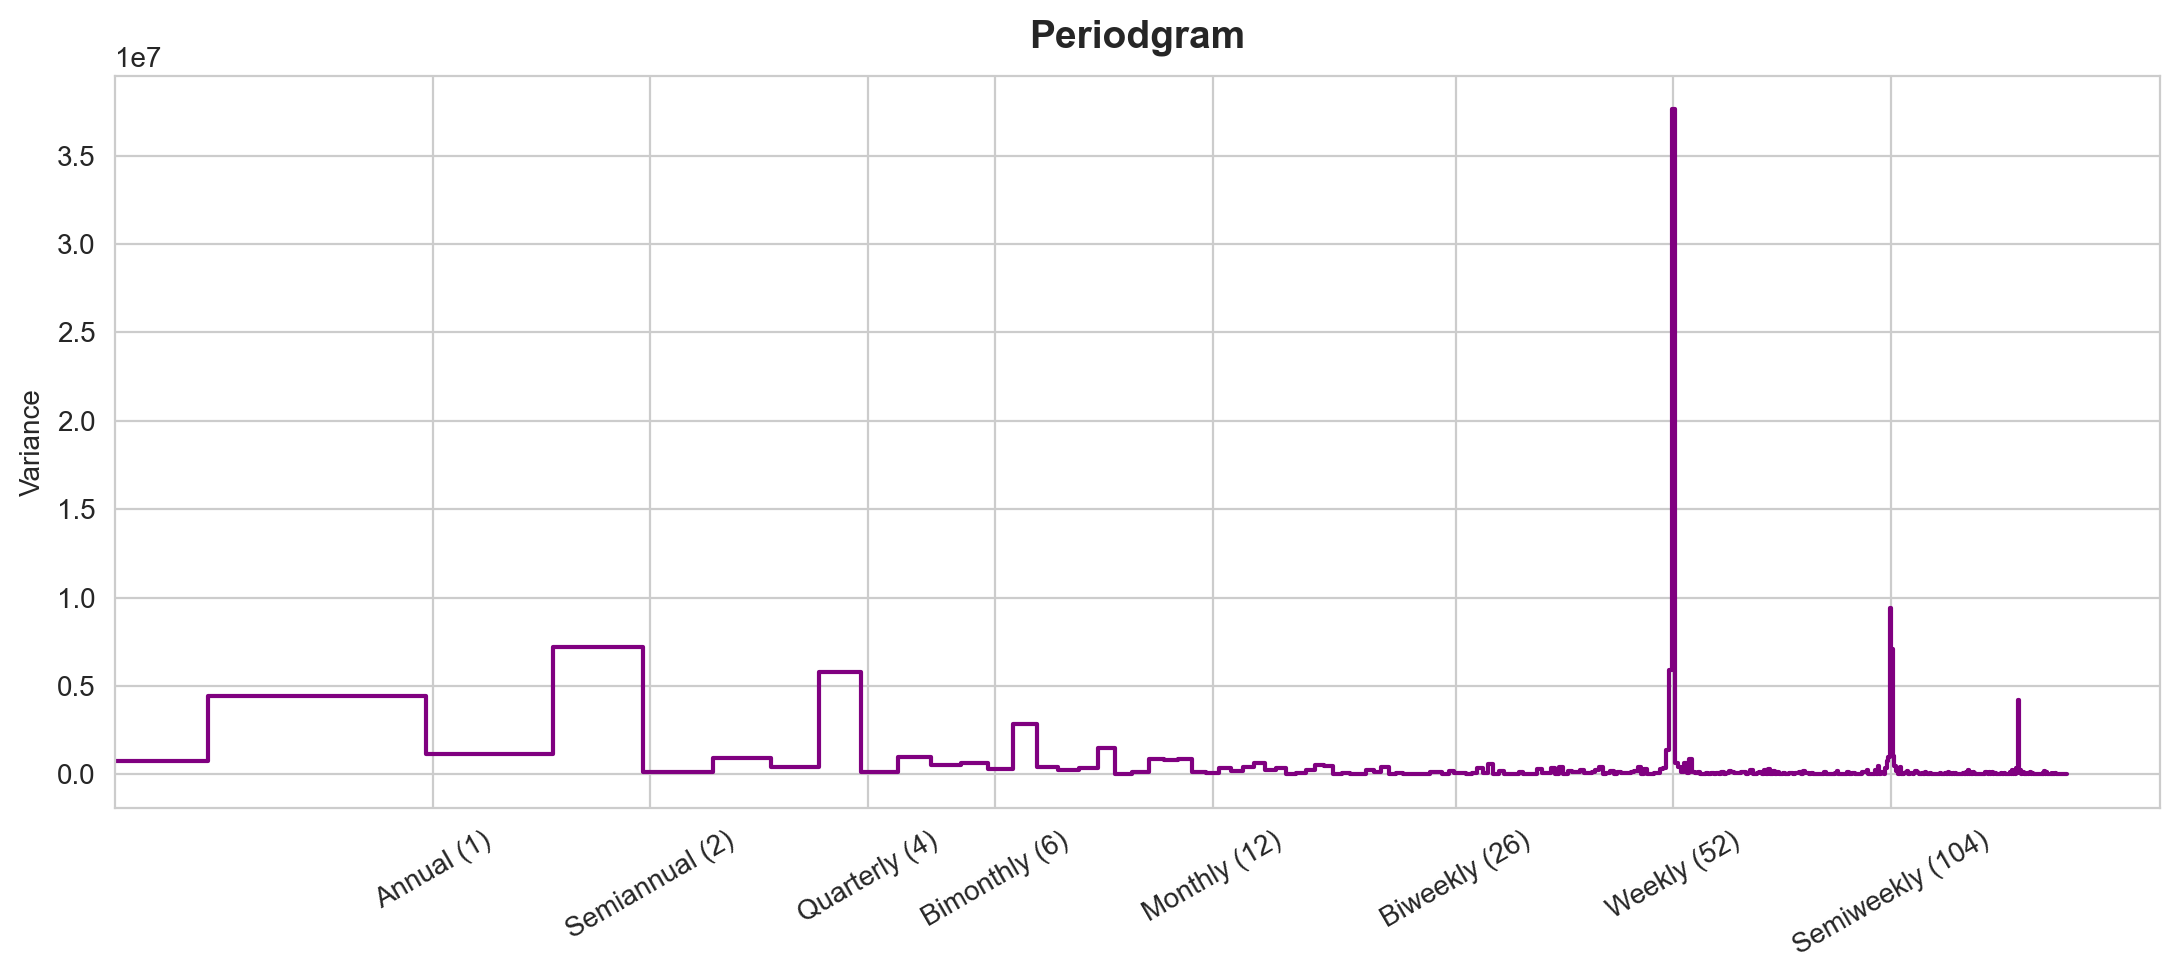

In [112]:
plot_periodogram(tunnel.NumVehicles);

- Strong weekly season
- Weaker annual season

In [115]:
fourier = CalendarFourier(freq="A",order=10) #10 sin/cos pairs for annual seasonality

In [117]:
dp = DeterministicProcess(
    index=tunnel.index,
    constant=True, # dummy feature for bias (y-intercept),
    order = 1,
    seasonal= True, # Weekly seasonality (indicators),
    additional_terms=[fourier], # annual seasonality (fourier)
    drop=True, # drop terms to avoid collinearity
)

X = dp.in_sample()

In [118]:
X.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)",...,"sin(6,freq=A-DEC)","cos(6,freq=A-DEC)","sin(7,freq=A-DEC)","cos(7,freq=A-DEC)","sin(8,freq=A-DEC)","cos(8,freq=A-DEC)","sin(9,freq=A-DEC)","cos(9,freq=A-DEC)","sin(10,freq=A-DEC)","cos(10,freq=A-DEC)"
Day,,,,,,,,,,,,,,,,,,,,,
2003-11-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.867456,0.497513,...,-0.017213,0.999852,-0.875892,0.482508,-0.854322,-0.519744,0.025818,-0.999667,0.880012,-0.474951
2003-11-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.858764,0.512371,...,0.085965,0.996298,-0.811539,0.584298,-0.917584,-0.397543,-0.128748,-0.991677,0.785650,-0.618671
2003-11-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.849817,0.527078,...,0.188227,0.982126,-0.735417,0.677615,-0.963471,-0.267814,-0.280231,-0.959933,0.668064,-0.744104
2003-11-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.840618,0.541628,...,0.288482,0.957485,-0.648630,0.761104,-0.991114,-0.133015,-0.425000,-0.905193,0.530730,-0.847541
2003-11-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.831171,0.556017,...,0.385663,0.922640,-0.552435,0.833556,-0.999991,0.004304,-0.559589,-0.828770,0.377708,-0.925925


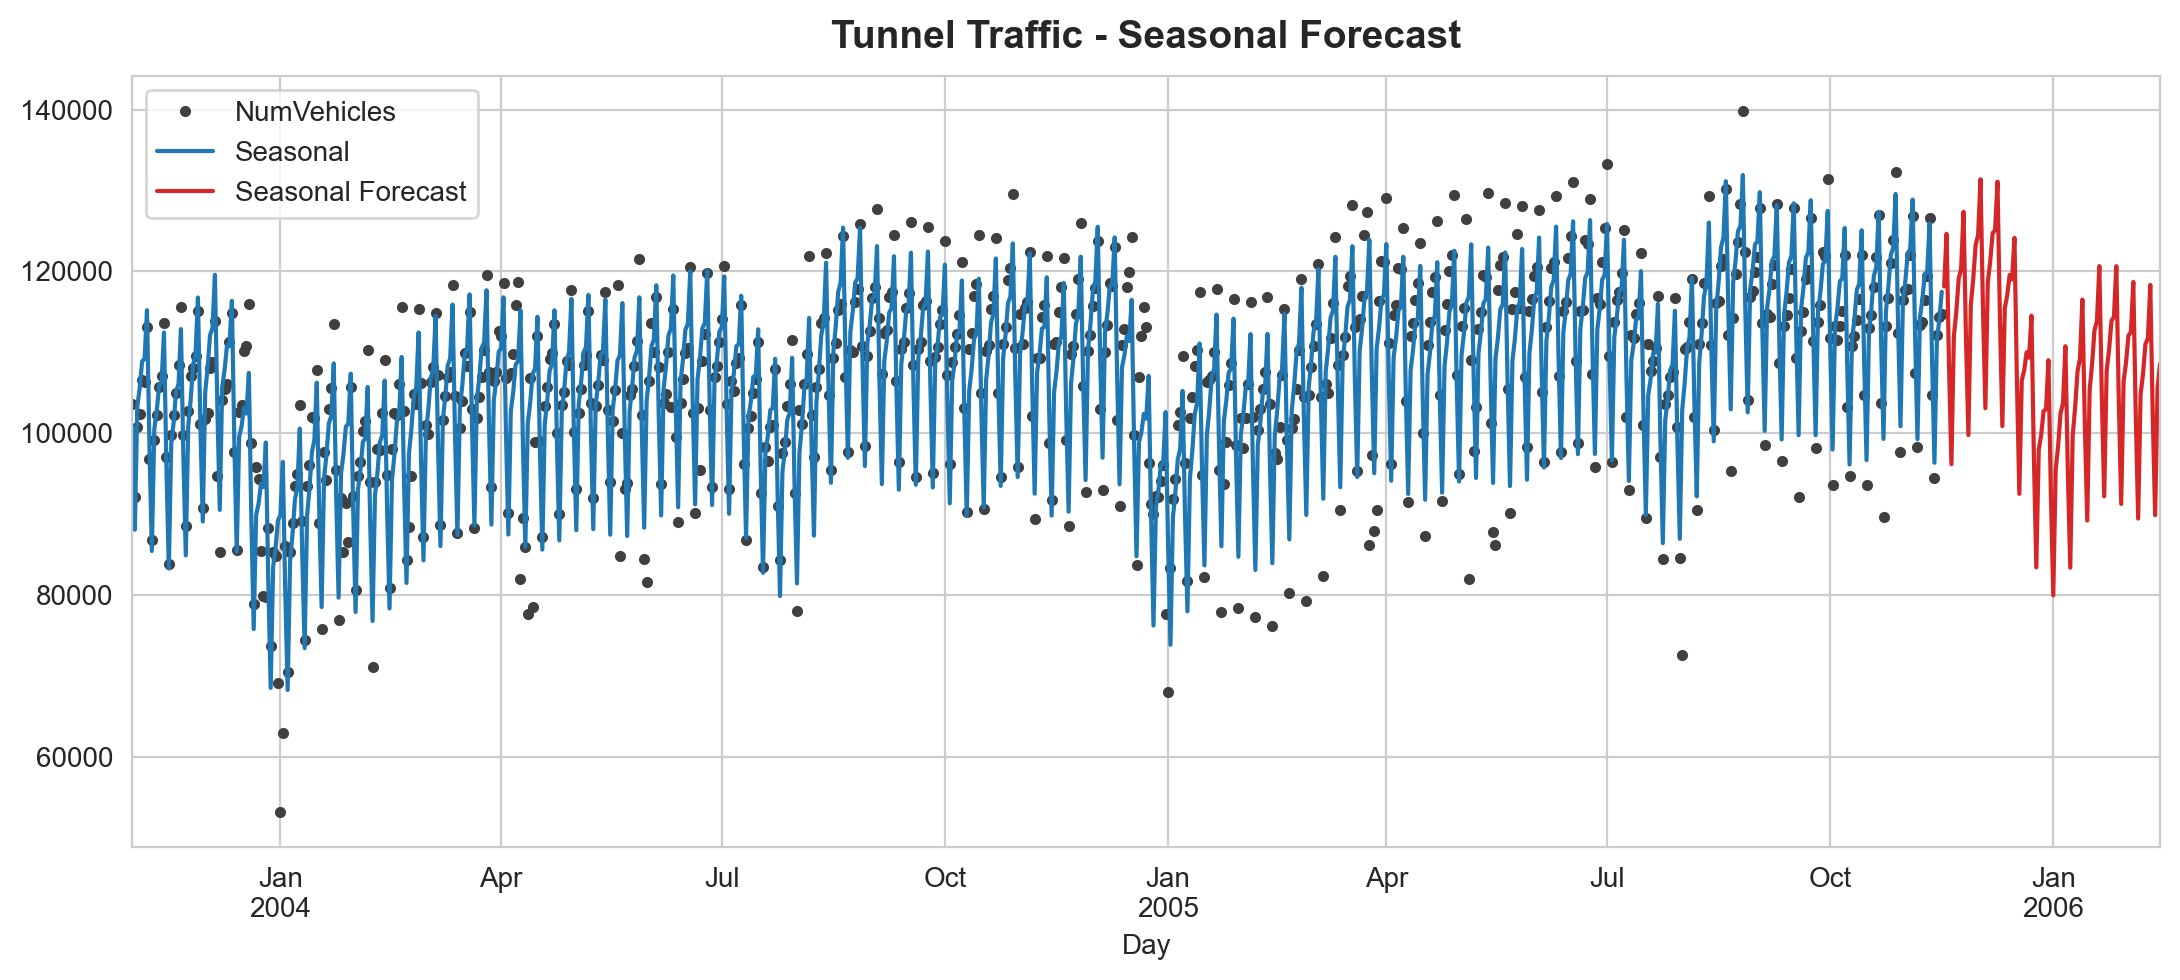

In [119]:
y = tunnel["NumVehicles"]

model = LinearRegression(fit_intercept=False)
model.fit(X,y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=90,)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="Tunnel Traffic - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color="C3")
ax.legend()